<a href="https://www.kaggle.com/code/mattiaskimst/enefit-kaggle-ids-h9?scriptVersionId=154408758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import json
import lightgbm as lgb
import torch
from geopy.geocoders import Nominatim
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [2]:
# Asukohtade dataset https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
location = (pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )
#vajalik, et koordinaatidena antud asukohad maakondadega kokku viia

In [3]:
#Loeme sisse andemd
train=pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
gas_prices=pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
forecast_weather=pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv')
electricity_prices=pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv')
client=pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
historical_weather=pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')

In [4]:
#allikas: https://www.kaggle.com/code/rafiko1/enefit-xgboost-starter
#loob sisendina antud kuuest datasetist ühe, 56 veeruga dataseti, mis sobib mudelite treenimiseks
#enefiti poolt antud datasetides on asukohad koordinaatides, teeb need location df abil maakondadeks
#kasutame, sest ise datasetide töötlemine sobivale kujule ja asukohtade maakondadeks teisendamine osutus oodatust keerukamaks
#silmas tuleb pidada, paljude erinevate kuupäevade puhul, mis väärtus, mingil kindlal kuupäeval teada on, kas väärtus on mõõdetud tulemus või ennustus jne


class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
     # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])

        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week.astype(int)  # Convert to integer
        data['hour'] = data['datetime'].dt.hour

        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month'] = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week

        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_convert('Europe/Brussels') # change to different time zone?
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df
    


Võistluse teistes mudelites on väga populaarne kasutada n days lag featureid, mis annavad väga palju täpsust juurde. Kuna meie oleme algajad, siis selleks, et kogu kood üle pea ei hakkaks käima loobusime sellest, sest see lisaks df töötlemisele ja mudelile palju keerukust.

In [5]:
FeatureProcessor=FeatureProcessorClass()
#loome ühise df
df_with_target = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity_prices.copy(),
                      gas = gas_prices.copy(),
                     )

target = 'target' #eraldame ennustatava väärtuse treeningandmetest
df = df_with_target[df_with_target[target].notnull()].reset_index(drop=True)


#treening ja valideerimishulgaks jagamine, kokku 637 data_block_id väärtust
train_block_id = list(range(0, 600)) 
tr = df[df['data_block_id'].isin(train_block_id)] #võtame esimesed 600 treeninghulka ja 37 valideerimis
val = df[~df['data_block_id'].isin(train_block_id)] 


# veerud, mis ei ole seotud ennustatava väärtusega nt rea number ehk mida mudelile ette ei tasu anda
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               'data_block_id'
               ]

remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]
remove_columns.append(target)
features = [col for col in df.columns if col not in remove_columns]

In [6]:
#millised veerud on meil treeningandmetes ja mis tüüpi need on
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 57 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   county                                    category      
 1   is_business                               category      
 2   product_type                              category      
 3   target                                    float64       
 4   is_consumption                            category      
 5   datetime                                  datetime64[ns]
 6   data_block_id                             category      
 7   row_id                                    int64         
 8   prediction_unit_id                        int64         
 9   date                                      datetime64[ns]
 10  year                                      int32         
 11  quarter                                   int32         
 12  month         

Ülevaade kuidas aja jookusl target väärtused kõiguvad

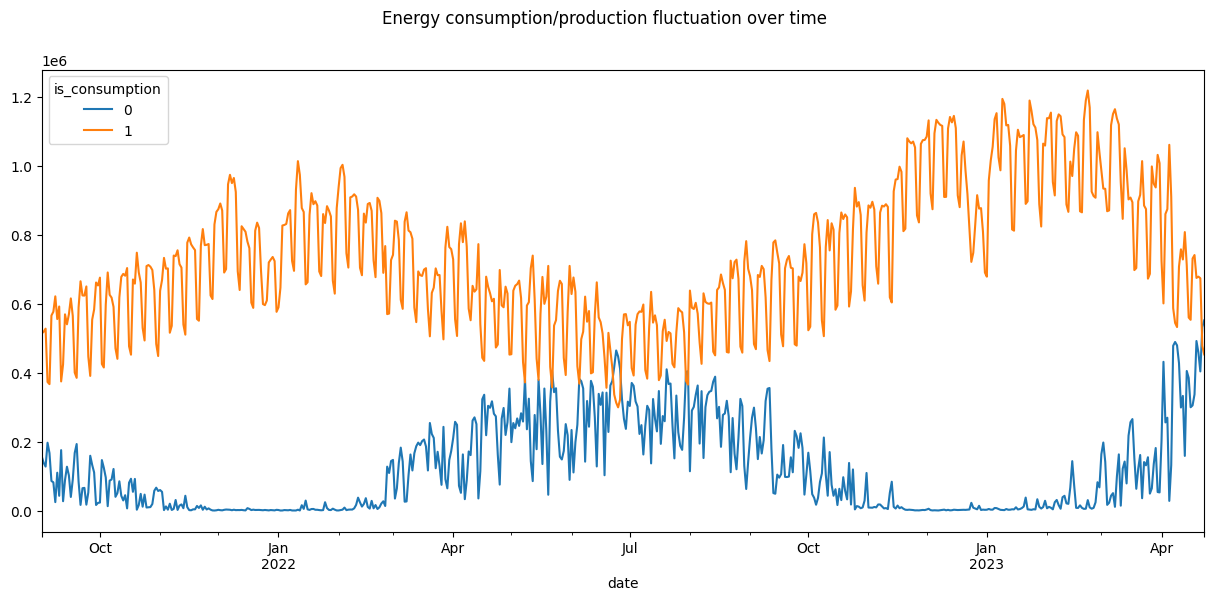

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))  

fig.suptitle('Energy consumption/production fluctuation over time')
tr.groupby(['is_consumption','date'])['target'].sum().unstack(0).plot(ax=ax) 
plt.savefig('con_prod_year.png')

Kasutame LGBM - Light Gradient Boosting - põhineb decision tree algortimil
<br>
<br>
LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.
<br>
<br>
Valisime LGBM 
<br>
1) Kiiruse tõttu - katsetasime ka xgboostiga, kuid oli oluliselt aeglasem ja seega ebamugavam muudatustega katsetada, lihtsamad mudelid, nt random forest on veelgi kordades aeglasemad sest ei kasuta n-ö boostingut
<br>
2) LGBM on väga sobilik time-series ülesannete ja suurte andmemahtude korral
<br>
<br>
Valikus olid ka Catboost, XGboost ja LSTM, esimesed on sarnased LGBM mudelile, st põhinevad desicsion tree tehnoloogial, viimane neist põhineb neurovõrgul. Kõik nimetatud mudelid oleksid olnud aeglasemad treenida.
<br>
<br>
LGBM mudel on kiire, kuid valede parameetrite korral võib lihtsasti üle treenida
<br>
<br>
Sobivate parameetrite leidmiseks kasutame cross-validationit
<br>
<br>
CV tähendab, et hindame oma mudeli jõudlust erinevate parameetrite komplektidega ja leiame sobivaima
<br>
<br>
Kasutame fold=3=k ehkandmed jagatakse k osaks (folds). Igas osa kasutatakse kordamööda valideerimisandmetena, samal ajal kui ülejäänud osad moodustavad treeningandmed, mis aitab vältida ületreenimist




In [8]:
#cross-validation
sample_size=int(0.1 * len(df))# et terve igavik ei kuluks kasutame juhuslikult 10% andmetest
df_cv=df.sample(n=sample_size, random_state=42).reset_index(drop=True)
X = df_cv[features]
y = df_cv[target]

#LightGBM parameetrid
model_lgbm = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression_l1',
    metric='mean_absolute_error',
    importance_type='split',
    learning_rate=0.08,
    n_estimators=2100,
    max_depth=11,
    min_child_samples=120,
    num_leaves=780,
    colsample_bytree=0.85,
    subsample=0.85,
    reg_alpha=2.321,
    reg_lambda=1.414,
    random_state=42
)

#Parameetrite listid, mida proovime läbi, kombineeirme omavahel
#param_grid = {
#    'objective':['regression_l1', 'regression'],
#}

# GridSearchCV kasutamine parameetrite häälestamiseks
#grid = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
#grid.fit(X, y)


In [9]:
#LightGBM
model_lgbm = lgb.LGBMRegressor(
    boosting_type='gbdt', #gradient boosting decision trees) algoritmi tüübi. GBDT on kõige levinum tüüp, mis loob puud järjestikku, iga järgnev puu püüab parandada eelmiste puude vigu.
    objective='regression_l1', #kaofunktsiooniks absoluutviga (L1), mis püüab minimeerida ennustuste ja tegelike väärtuste vahelist absoluutset erinevust.
    metric='mean_absolute_error',#kasutatakse mudeli jõudluse hindamiseks treenimise ajal. Keskmise absoluutvea (MAE) puhul arvutatakse ennustuste ja tegelike väärtuste vaheliste erinevuste absoluutväärtuste keskmine.
    importance_type='split',#kuidas tunnuste tähtsust arvutatakse. ‘Split’ tähendab, et tähtsus määratakse selle järgi, mitu korda tunnust kasutatakse puudes otsustamiseks
    learning_rate=0.08,
    n_estimators=2000,#mitu järjestikust puud (estimators) mudel ehitab.
    max_depth=10,#Määrab puu maksimaalse sügavus. See piirab puu kasvu ja aitab vältida üleõppimist.
    min_child_samples=100,#minimaalne andmepunktide arv, mis on vajalik puu lehes (child). Aitab vältida üleõppimist.
    num_leaves=500, #maksimaalse lehtede arv puus. Suurem arv võib suurendada mudeli keerukust ja üleõppimise riski.
    colsample_bytree=0.85,#milline osa tunnustest valitakse igal iteratsioonil puu ehitamiseks.
    subsample=0.85,#milline osa andmekogumist valitakse igal iteratsioonil puu ehitamiseks. 
    reg_alpha=2.321,# reg_... aitavad vältida üleõppimist, lisades mudeli kaaludele karistusi.
    reg_lambda=1.414,
    random_state=42 #mudeli tulemuste reprodutseeritavuse jaoks
)

model_lgbm.fit(
    X=tr[features], 
    y=tr[target], 
    eval_set=[(tr[features], tr[target]), (val[features], val[target])],
    eval_metric='l1',  
    early_stopping_rounds=10,  
    
)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513

[1]	valid_0's l1: 254.838	valid_1's l1: 329.262
[2]	valid_0's l1: 245.771	valid_1's l1: 318.658
[3]	valid_0's l1: 236.917	valid_1's l1: 307.904
[4]	valid_0's l1: 227.626	valid_1's l1: 297.025
[5]	valid_0's l1: 225.043	valid_1's l1: 289.51
[6]	valid_0's l1: 216.973	valid_1's l1: 281.502
[7]	valid_0's l1: 209.093	valid_1's l1: 272.627
[8]	valid_0's l1: 201.806	valid_1's l1: 264.957
[9]	valid_0's l1: 195.166	valid_1's l1: 257.904
[10]	valid_0's l1: 188.368	valid_1's l1: 250.246
[11]	valid_0's l1: 181.309	valid_1's l1: 242.5
[12]	valid_0's l1: 172.644	valid_1's l1: 232.727
[13]	valid_0's l1: 166.808	valid_1's l1: 226.23
[14]	valid_0's l1: 161.041	valid_1's l1: 218.841
[15]	valid_0's l1: 155.147	valid_1's l1: 212.339
[16]	valid_0's l1: 149.433	valid_1's l1: 207.257
[17]	valid_0's l1: 142.924	valid_1's l1: 202.59
[18]	valid_0's l1: 135.584	valid_1's l1: 196.477
[19]	valid_0's l1: 128.64	valid_1's l1: 191.624
[20]	valid_0's l1: 123.013	valid_1's l1: 186.575
[21]	valid_0's l1: 117.215	valid_1'

LGBMRegressor(colsample_bytree=0.85, learning_rate=0.08, max_depth=10,
              metric='mean_absolute_error', min_child_samples=100,
              n_estimators=2000, num_leaves=500, objective='regression_l1',
              random_state=42, reg_alpha=2.321, reg_lambda=1.414,
              subsample=0.85)

Vaatame MAE loss, ehk kui hästi mudel õpib andmetest, madalam on parem, kui validation on oluliselt kõrgem, võib tegu olla ületreenimisega

Mida me saame siit skeemilt?
<br>
Learning Trend: By examining the graph, you can assess whether the model is learning effectively. Ideally, the MAE should decrease over time as the model becomes better at predicting the target variable.
<br>
Overfitting: If the training MAE continues to decrease while the validation MAE starts to increase, it could indicate that the model is overfitting to the training data and not generalizing well to unseen data.
<br>
Underfitting: Conversely, if both training and validation MAE are high or do not improve significantly with more iterations, the model might be underfitting and too simplistic to capture the underlying patterns in the data.
<br>
Optimal Iterations: The point at which the validation MAE is at its lowest can suggest the optimal number of iterations before the model begins to overfit.

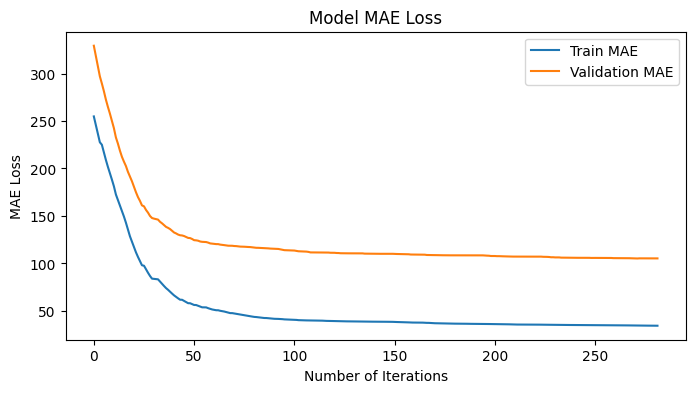

In [10]:
results = model_lgbm.evals_result_
train_mae, val_mae = results["valid_0"]["l1"], results["valid_1"]["l1"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_values, train_mae, label="Train MAE")
ax.plot(x_values, val_mae, label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.xlabel("Number of Iterations")  # Add this line to label the x-axis
plt.title("Model MAE Loss")
plt.savefig('MAE_loss.png')

Vaatame mudeli treenimisel kasutatud tunnuste tähtsusi. Tähtsus arvutatakse kui keskmine ja standardhälve puude lõikes kogunenud impurity vähenemisest. Iga kord, kui puu teeb haru (ehk otsustab andmed jagada), vaadatakse, kui palju see jagamine parandab mudeli täpsust. Parandust mõõdetakse impurity vähenemisega, mis on näitaja, kui hästi jagamine aitas eraldada erinevaid klasse.

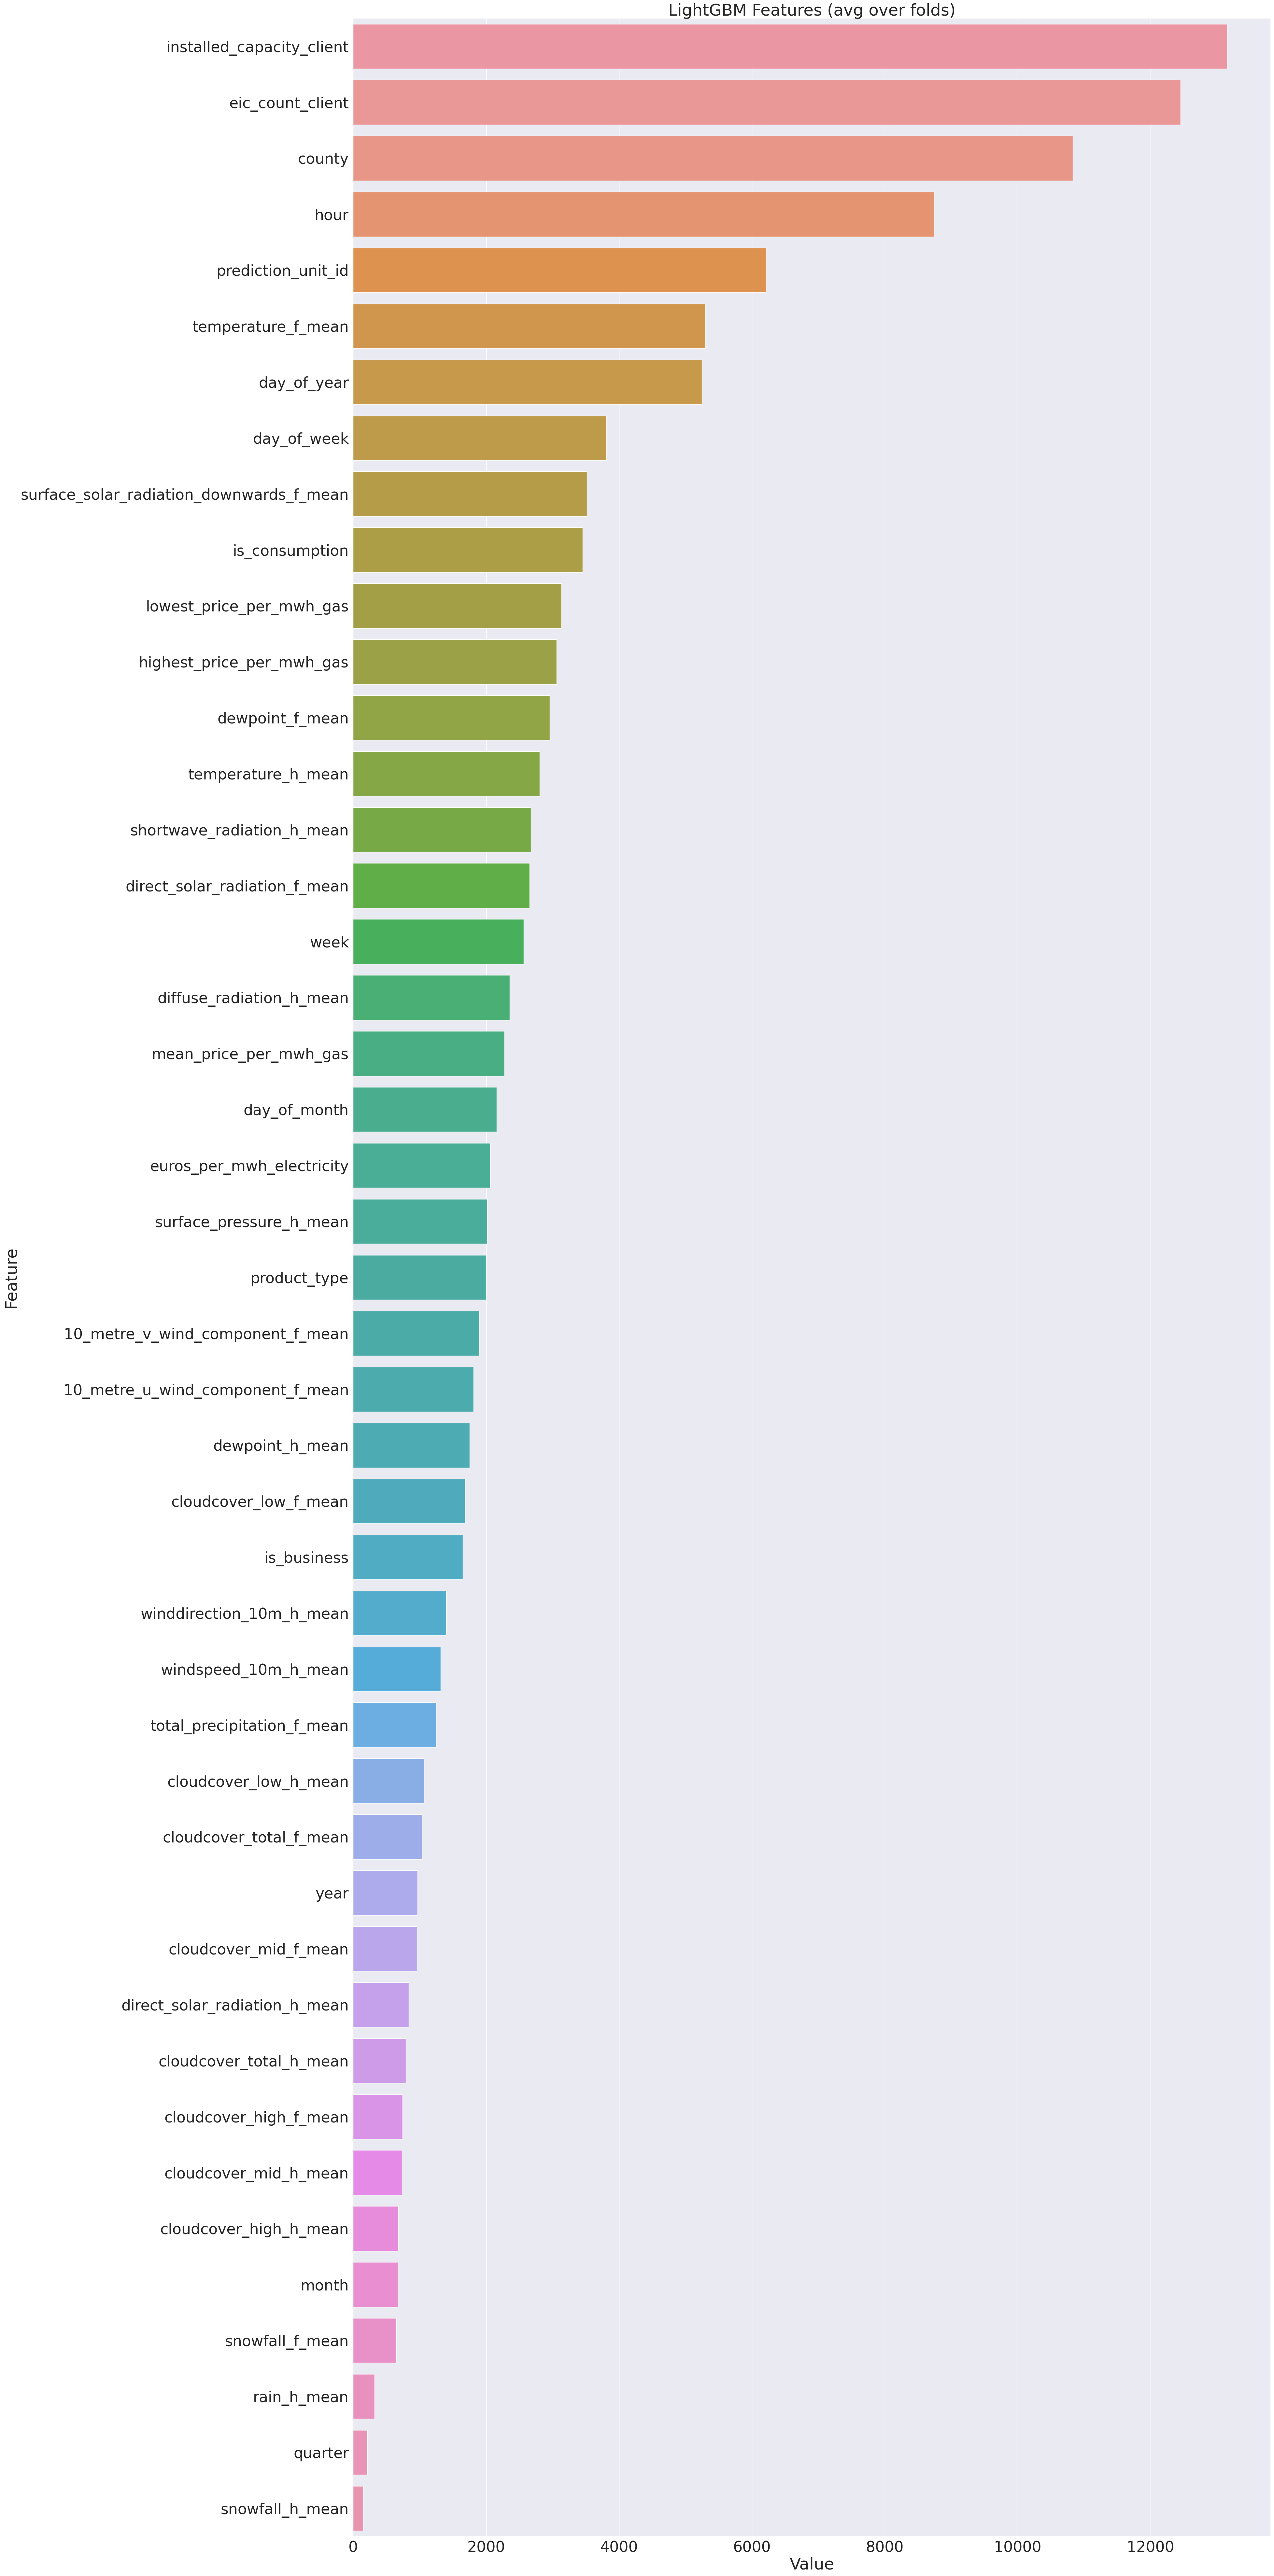

In [11]:
feature_imp = pd.DataFrame({'Value': model_lgbm.feature_importances_, 'Feature': features})
plt.figure(figsize=(40, 80))
sns.set(font_scale=3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('feature_importance.png')

Mudeli testimine võistlusel antud ENV abil, kus antakse ennustamise igal iteratsioonil ette ainult need andmed, mis on ennustuse ajahetkel olemas, et tagada, et mudel "ei vaataks tulevikku" ja see ei kallutaks ennustust

In [12]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

In [13]:
#ennustamine enefit env abil
for (test, 
     revealed_targets, 
     client_test, 
     historical_weather_test,
     forecast_weather_test, 
     electricity_test, 
     gas_test, 
     sample_prediction) in iter_test:
    
    test = test.rename(columns = {'prediction_datetime': 'datetime'})

    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    #eeltöötleme api antavad test andmed sanaloogselt train töötlusega
    data_test = FeatureProcessor(
                               data = test,
                               client = client_test, 
                               historical_weather = historical_weather_test,
                               forecast_weather = forecast_weather_test, 
                               electricity = electricity_test, 
                               gas = gas_test
                               )

    # ennustus
    X_test = data_test[features]
    sample_prediction['target'] = model_lgbm.predict(X_test)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


Mudeli tulemuste headusest arusaamiseks vaatame histogrammi treeningandmete "target" väärtuse jagunemisest. Vaatame ka algandmetest std ja keskmist, et aru saada, kas mudelist mingit kasu on.

count   2017824.00
mean        274.86
std         909.50
min           0.00
25%           0.38
50%          31.13
75%         180.21
max       15480.27
Name: target, dtype: float64


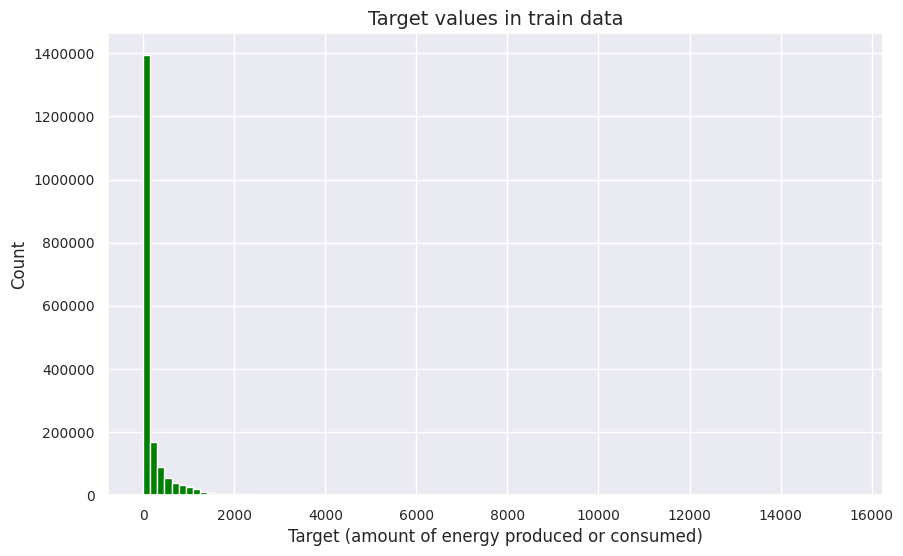

In [14]:

plt.figure(figsize=(10, 6))

tr['target'].hist(bins=100, color='green')
plt.xlabel('Target (amount of energy produced or consumed)', fontsize=12)  
plt.ylabel('Count', fontsize=12)  
plt.title('Target values in train data', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('distribution_target.png')


#uurime train set'i
pd.set_option('display.float_format', lambda x: '%.2f' % x)#et numbrid "normaalsed" oleksid
print(df['target'].describe())
